# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
import pandas as pd

df_2023 = pd.read_excel('/content/drive/MyDrive/관광공모전/원본데이터/2023 외래관광객조사 DATA.xlsx')
df_2024 = pd.read_excel('/content/drive/MyDrive/관광공모전/원본데이터/2024 외래관광객조사_Data.xlsx')

# 연관분석

## 분석 대상 필터링


In [ ]:
import pandas as pd

# 필요한 컬럼만 지정해서 로딩
usecols_2023 = ['Q8_1a1', 'Q8_1a2', 'Q8_1a3', 'Q11', 'Q13', 'D_NAT']
usecols_2024 = ['Q8_1a_1', 'Q8_1a_2', 'Q8_1a_3', 'Q11', 'Q13', 'D_NAT']

# 컬럼명 통일
df_2024.rename(columns={
    'Q8_1a_1': 'Q8_1a1',
    'Q8_1a_2': 'Q8_1a2',
    'Q8_1a_3': 'Q8_1a3'
}, inplace=True)

# 연도 정보 추가
df_2023['year'] = 2023
df_2024['year'] = 2024


In [ ]:
#연도별 활동 코드 매핑
q8_1a_map_2023 = {
    1: '식도락', 2: '쇼핑', 3: '자연경관 감상', 4: '고궁/역사 유적지 방문',
    5: '전통문화체험', 6: '박물관, 전시관 관람', 7: '한류스타/K-POP 공연장 방문',
    8: '공연(연극, 뮤지컬 등) 관람', 9: '지역 축제 참여', 10: '유흥/카지노',
    11: '놀이공원/테마파크 방문', 12: '뷰티/미용 관광', 13: '의료 관광',
    14: '스포츠 관람', 15: '스포츠 참가', 16: '국제회의/전시회',
    17: '비즈니스 활동', 18: '연수/교육/연구', 19: '기타'
}

q8_1a_map_2024 = {
    1: '식도락', 2: '쇼핑', 3: '자연경관 감상', 4: '휴양/휴식(웰니스)', 5: '고궁/역사 유적지 방문',
    6: '전통문화체험', 7: '박물관, 전시관 관람', 8: '한류스타/K-POP 공연장 방문',
    9: '공연(연극, 뮤지컬 등) 관람', 10: '지역 축제 참여', 11: '유흥/카지노',
    12: '놀이공원/테마파크 방문', 13: '뷰티/미용 관광', 14: '의료 관광',
    15: '스포츠 관람', 16: '스포츠 참가', 17: '국제회의/전시회',
    18: '비즈니스 활동', 19: '연수/교육/연구', 20: '기타'
}

def extract_activities(row, year):
    if year == 2023:
        mapper = q8_1a_map_2023
    else:
        mapper = q8_1a_map_2024
    return [mapper.get(row[col]) for col in ['Q8_1a1', 'Q8_1a2', 'Q8_1a3'] if row[col] in mapper]


# 필터링 후 item_list 생성
df_2023['item_list'] = df_2023.apply(lambda row: extract_activities(row, 2023), axis=1)
df_2024['item_list'] = df_2024.apply(lambda row: extract_activities(row, 2024), axis=1)

# 병합
df_all = pd.concat([df_2023, df_2024], ignore_index=True)


In [ ]:
# 클러스터 1 국가 리스트
country_code_map = {
    1: '중국',
    2: '일본',
    3: '대만',
    4: '미국',
    5: '홍콩',
    6: '태국',
    7: '베트남',
    8: '말레이시아',
    9: '필리핀',
    10: '싱가포르',
    11: '러시아',
    12: '중동',
    13: '인도네시아',
    14: '캐나다',
    15: '호주',
    16: '영국',
    17: '몽골',
    18: '독일',
    19: '프랑스',
    20: '인도',
    97: '기타'
}
df_all['국가명'] = df_all['D_NAT'].map(country_code_map)

cluster1_countries = ['기타', '독일', '미국', '영국', '캐나다', '프랑스', '호주']


/tmp/ipython-input-7-2359080322.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all['국가명'] = df_all['D_NAT'].map(country_code_map)


In [ ]:
# 타깃 추출 (item_list 포함 + 재방문의향 4~5)
df_target = df_all[
    (df_all['국가명'].isin(cluster1_countries)) &
    (df_all['Q13'].isin([4, 5])) &
    (df_all['item_list'].notna()) &
    (df_all['item_list'].apply(lambda x: len(x) > 0))
].copy()

In [ ]:
df_target['Q13'].unique()

array([5, 4])

In [ ]:
df_all['item_list'].head()

,item_list
0,"[공연(연극, 뮤지컬 등) 관람, 식도락, 쇼핑]"
1,"[놀이공원/테마파크 방문, 쇼핑, 자연경관 감상]"
2,[식도락]
3,"[스포츠 참가, 고궁/역사 유적지 방문, 국제회의/전시회]"
4,"[쇼핑, 고궁/역사 유적지 방문, 식도락]"


## 연관분석 수행

In [ ]:
%%capture
pip install mlxtend

### 트랜잭션 인코딩

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

# item_list를 리스트로 변환
transactions = df_target['item_list'].tolist()

# 트랜잭션 인코더로 변환
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

# DataFrame으로 변환
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

### 2단계: Apriori 알고리즘 적용

In [ ]:
from mlxtend.frequent_patterns import apriori

# 최소 지지도 설정하여 자주 등장하는 활동 조합 찾기
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)


### 3단계: 연관규칙 추출

In [ ]:
from mlxtend.frequent_patterns import association_rules

# 신뢰도 기준으로 연관규칙 도출
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# lift 기준 정렬 (높을수록 강한 연관관계)
rules_sorted = rules.sort_values(by="lift", ascending=False)


### 결과 확인

In [ ]:
# 필요한 컬럼만 보기 좋게 출력
rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20)


,antecedents,consequents,support,confidence,lift
22,(의료 관광),(쇼핑),0.010932,0.530864,1.375596
16,(뷰티/미용 관광),(쇼핑),0.023643,0.492063,1.275054
1,"(박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.127749,0.584302,1.175328
32,"(자연경관 감상, 박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.039659,0.562162,1.130793
9,(전통문화체험),(고궁/역사 유적지 방문),0.094954,0.554154,1.114685
8,(고궁/역사 유적지 방문),(자연경관 감상),0.201856,0.406034,1.075875
7,(자연경관 감상),(고궁/역사 유적지 방문),0.201856,0.534860,1.075875
43,"(비즈니스 활동, 쇼핑)",(식도락),0.014745,0.477366,1.012248
29,(휴양/휴식(웰니스)),(자연경관 감상),0.015254,0.379747,1.006220
19,(식도락),(쇼핑),0.181899,0.385714,0.999478


In [ ]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7867 entries, 2 to 32411
Columns: 439 entries, pnid to 국가명
dtypes: float64(371), int64(65), object(3)
memory usage: 26.4+ MB


In [ ]:
# 조건 기준
filtered_rules = rules[
    (rules['support'] >= 0.05) &
    (rules['confidence'] >= 0.5) &
    (rules['lift'] >= 1.0)
].sort_values(by='lift', ascending=False)

filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
1,"(박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.127749,0.584302,1.175328
9,(전통문화체험),(고궁/역사 유적지 방문),0.094954,0.554154,1.114685
7,(자연경관 감상),(고궁/역사 유적지 방문),0.201856,0.534860,1.075875


In [ ]:
df_target['Q12a01'].unique()

array([ 5., nan,  4.,  3.,  2.,  1.])

## 1회방문자 VS 재방문자의 연관분석 비교

In [ ]:
# usecols에 'RVIT' 추가
usecols_2023 = ['Q8_1a1', 'Q8_1a2', 'Q8_1a3', 'Q11', 'Q13', 'D_NAT', 'RVIT']
usecols_2024 = ['Q8_1a_1', 'Q8_1a_2', 'Q8_1a_3', 'Q11', 'Q13', 'D_NAT', 'RVIT']


In [ ]:
# 만족도 4 이상 + 클러스터1 국가
df_filtered = df_all[
    (df_all['국가명'].isin(cluster1_countries)) &
    (df_all['Q11'] >= 4) &  # 논문 방식은 Q13 말고 Q11 기준
    (df_all['item_list'].notna()) &
    (df_all['item_list'].apply(lambda x: len(x) > 0))
].copy()

# 1회 vs 재방문 구분
df_once = df_filtered[df_filtered['RVIT'] == 1]
df_repeat = df_filtered[df_filtered['RVIT'] >= 2]

## 연관분석 수행 2

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def run_association_analysis(transactions, min_support=0.03, min_conf=0.5):
    te = TransactionEncoder()
    te_array = te.fit(transactions).transform(transactions)
    df_tf = pd.DataFrame(te_array, columns=te.columns_)

    freq_items = apriori(df_tf, min_support=min_support, use_colnames=True)
    rules = association_rules(freq_items, metric="confidence", min_threshold=min_conf)

    return rules.sort_values(by="confidence", ascending=False)


In [ ]:
# item_list → transactions
transactions_once = df_once['item_list'].tolist()
transactions_repeat = df_repeat['item_list'].tolist()

# 규칙 도출
rules_once = run_association_analysis(transactions_once)
rules_repeat = run_association_analysis(transactions_repeat)

In [ ]:
print("🔵 1회 방문자 규칙 상위 10개")
display(rules_once[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

print("🟢 재방문자 규칙 상위 10개")
display(rules_repeat[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


🔵 1회 방문자 규칙 상위 10개


,antecedents,consequents,support,confidence,lift
0,"(박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.165420,0.623909,1.056019
2,(자연경관 감상),(고궁/역사 유적지 방문),0.246083,0.611234,1.034566
4,"(자연경관 감상, 박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.056624,0.609195,1.031116
3,(전통문화체험),(고궁/역사 유적지 방문),0.120370,0.573854,0.971297
1,(식도락),(고궁/역사 유적지 방문),0.237714,0.522096,0.883693


🟢 재방문자 규칙 상위 10개


,antecedents,consequents,support,confidence,lift
0,"(박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.085443,0.529412,1.450946
2,(쇼핑),(식도락),0.203481,0.518548,1.053770
1,(전통문화체험),(고궁/역사 유적지 방문),0.054747,0.501449,1.374310


In [ ]:
def filter_rules(rules, min_support=0.05, min_conf=0.5, min_lift=1.0):
    return rules[
        (rules['support'] >= min_support) &
        (rules['confidence'] >= min_conf) &
        (rules['lift'] >= min_lift)
    ].sort_values(by='lift', ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

# 필터링된 결과
filtered_once = filter_rules(rules_once)
filtered_repeat = filter_rules(rules_repeat)

# 출력
print("🔵 필터링된 1회 방문자 규칙")
display(filtered_once)

print("🟢 필터링된 재방문자 규칙")
display(filtered_repeat)

🔵 필터링된 1회 방문자 규칙


,antecedents,consequents,support,confidence,lift
0,"(박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.165420,0.623909,1.056019
2,(자연경관 감상),(고궁/역사 유적지 방문),0.246083,0.611234,1.034566
4,"(자연경관 감상, 박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.056624,0.609195,1.031116


🟢 필터링된 재방문자 규칙


,antecedents,consequents,support,confidence,lift
0,"(박물관, 전시관 관람)",(고궁/역사 유적지 방문),0.085443,0.529412,1.450946
1,(전통문화체험),(고궁/역사 유적지 방문),0.054747,0.501449,1.374310
2,(쇼핑),(식도락),0.203481,0.518548,1.053770


## 각 활동별로 만족도가 높은 지역

In [ ]:
# 2023년 활동명 매핑
activity_map_2023 = {
    1: '식도락', 2: '쇼핑', 3: '자연경관 감상', 4: '고궁/역사 유적지 방문',
    5: '전통문화체험', 6: '박물관, 전시관 관람', 7: '한류/K-POP', 8: '공연 관람',
    9: '지역축제', 10: '유흥/카지노', 11: '놀이공원/테마파크', 12: '뷰티/미용',
    13: '의료 관광', 14: '스포츠 관람', 15: '스포츠 참가', 16: '국제회의',
    17: '비즈니스', 18: '연수/교육', 19: '기타'
}

# 2024년 활동명 매핑
activity_map_2024 = {
    1: '식도락', 2: '쇼핑', 3: '자연경관 감상', 4: '휴양/휴식(웰니스)', 5: '고궁/역사 유적지 방문',
    6: '전통문화체험', 7: '박물관, 전시관 관람', 8: '한류/K-POP', 9: '공연 관람',
    10: '지역축제', 11: '유흥/카지노', 12: '놀이공원/테마파크', 13: '뷰티/미용',
    14: '의료 관광', 15: '스포츠 관람', 16: '스포츠 참가', 17: '국제회의',
    18: '비즈니스', 19: '연수/교육', 20: '기타'
}


In [ ]:
# 결과 저장
activity_region_satisfaction = {}

# 연도별로 분리
df_2023_use = df_all[df_all['year'] == 2023]
df_2024_use = df_all[df_all['year'] == 2024]

# 공통 지역 변수
region_cols = {
    'Q9_2a01': '서울', 'Q9_2a02': '인천', 'Q9_2a03': '경기',
    'Q9_2a04': '강원', 'Q9_2a05': '대전', 'Q9_2a06': '세종',
    'Q9_2a07': '충북', 'Q9_2a08': '충남', 'Q9_2a09': '부산',
    'Q9_2a10': '울산', 'Q9_2a11': '경북', 'Q9_2a12': '경남',
    'Q9_2a13': '대구', 'Q9_2a14': '광주', 'Q9_2a15': '전북',
    'Q9_2a16': '전남', 'Q9_2a17': '제주'
}


In [ ]:
def weighted_avg(series, weights):
    mask = series.notna() & weights.notna()
    if mask.sum() == 0:
        return np.nan
    return np.average(series[mask], weights=weights[mask])


In [ ]:
def get_combined_region_score(df, activity_map):
    result = {}
    for i, act_name in activity_map.items():
        col = f"Q12a{str(i).zfill(2)}"
        if col not in df.columns:
            continue

        temp = df[['pnid', col, 'weight'] + list(region_cols.keys())].copy()
        temp[col] = pd.to_numeric(temp[col], errors='coerce')
        temp['weight'] = pd.to_numeric(temp['weight'], errors='coerce')

        region_avg = {}
        for qcol, rname in region_cols.items():
            if rname == '서울':  # ❗ 서울 제외
                continue

            subset = temp[temp[qcol].notna()]
            mean_score = weighted_avg(subset[col], subset['weight'])
            if pd.notna(mean_score):
                region_avg[rname] = mean_score

        result[act_name] = dict(sorted(region_avg.items(), key=lambda x: x[1], reverse=True))
    return result


In [ ]:
def plot_activity_satisfaction_with_values(region_score, activity_name, top_n=10):
    if activity_name not in region_score:
        print(f"[{activity_name}] 항목이 region_score에 없습니다.")
        return

    region_dict = region_score[activity_name]
    if not region_dict:
        print(f"[{activity_name}]에 대해 만족도 데이터가 없습니다.")
        return

    sorted_items = sorted(region_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    regions, scores = zip(*sorted_items)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(regions[::-1], scores[::-1], color='steelblue')
    plt.xlabel("가중 평균 만족도")
    plt.title(f"'{activity_name}' 만족도 높은 지역 (2023+2024, 서울 제외)")
    plt.xlim(0, 5)
    plt.grid(axis='x')

    # 점수 텍스트 표시
    for bar, score in zip(bars, scores[::-1]):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2, f"{score:.2f}", va='center')

    plt.tight_layout()
    plt.show()


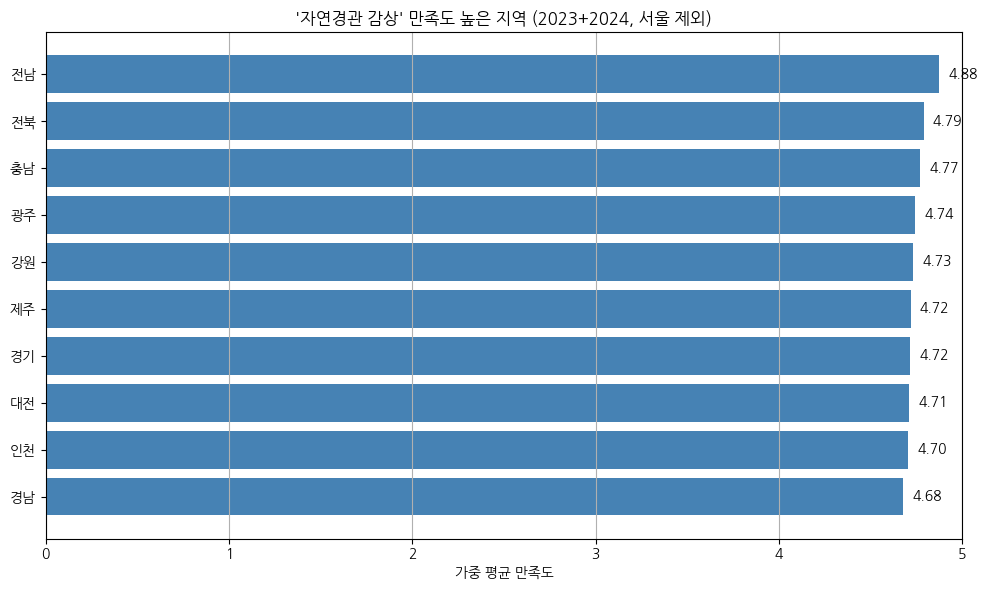

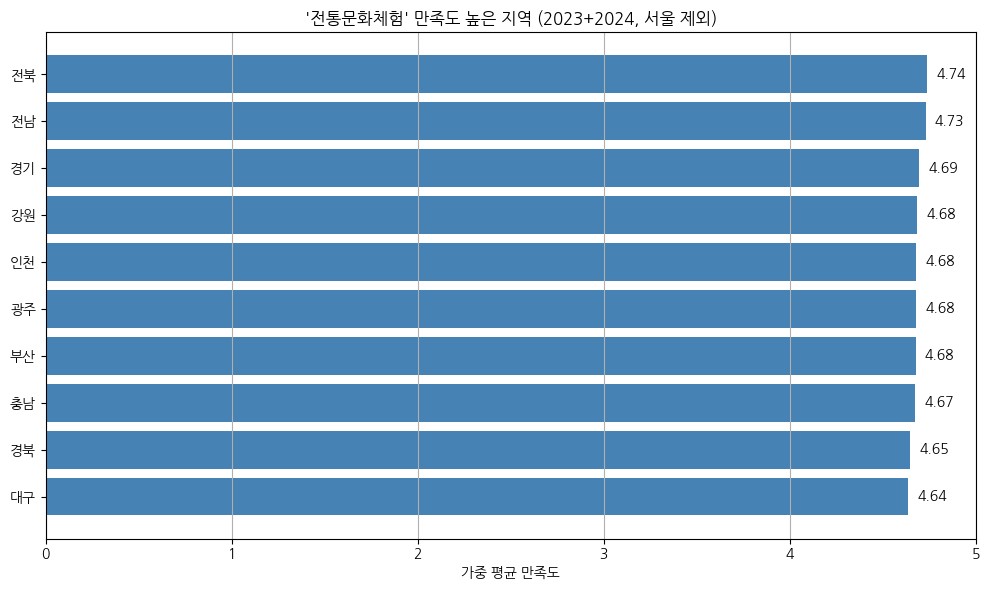

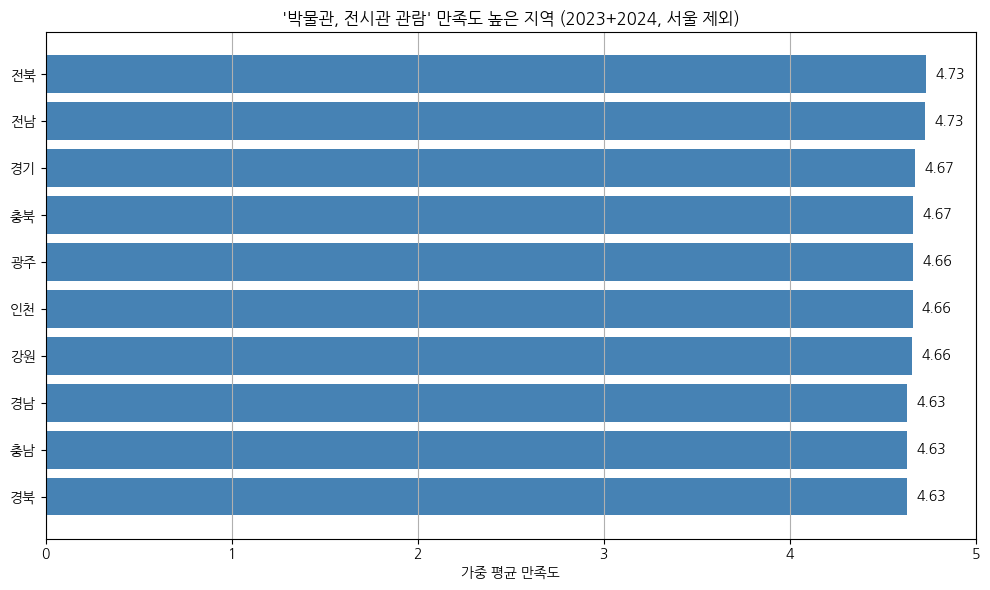

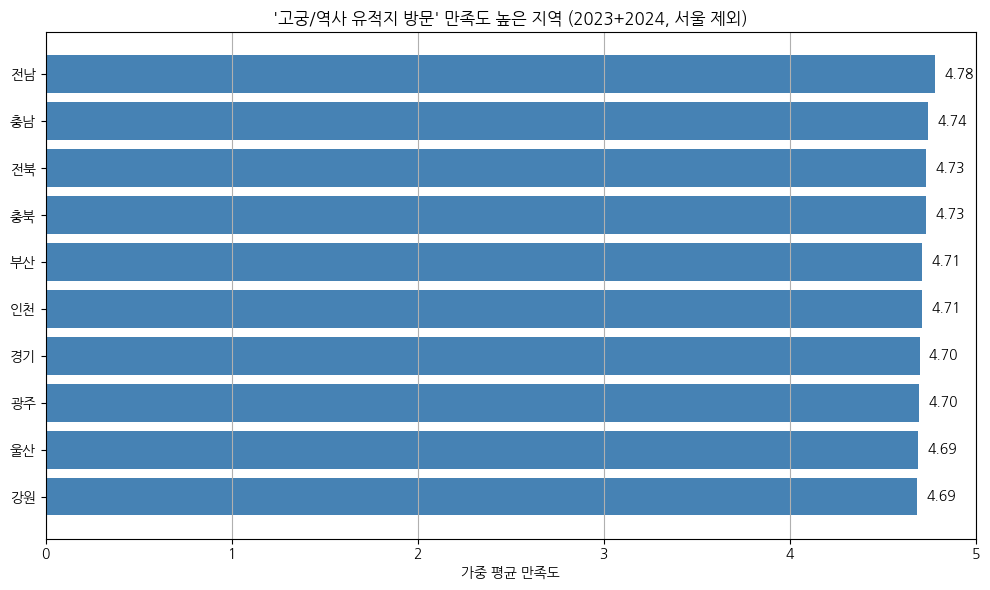

In [ ]:
# 1. 2023, 2024 통합
df_both = pd.concat([df_2023_use, df_2024_use], ignore_index=True)

activity_map_common =  {
     3: '자연경관 감상',
     4: '고궁/역사 유적지 방문',
     5: '전통문화체험',
     6: '박물관, 전시관 관람'
}

# 2. 지역별 가중 평균 만족도 계산
region_score_combined = get_combined_region_score(df_both, activity_map_common)

# 3. 시각화
plot_activity_satisfaction_with_values(region_score_combined, '자연경관 감상')
plot_activity_satisfaction_with_values(region_score_combined, '전통문화체험')
plot_activity_satisfaction_with_values(region_score_combined, '박물관, 전시관 관람')
plot_activity_satisfaction_with_values(region_score_combined, '고궁/역사 유적지 방문')
